# Convolutional neural network retrieval

Convolutional neural networks (CNNs) make it easy to leverage the additional structural information in the spatial retrieval input data for retrieving precipitation. This model demonstrates this using a basic UNet model.

> **NOTE**: This notebook can be run on Google Colab. To install the necessary dependencies uncomment the following cell and execute it.

In [1]:
#!pip install ipwgml[complete]@git+https://github.com/simonpf/ipwgml

## The training data
The SPR dataset comes in two input-data formats: *tabular* and *spatial*. The term *spatial* is used here to denote input data in 2D or image structure.
The ``ipwgml.pytorch.dataset.SPRSpatial`` implements the PyTorch dataset interface for loading SPR data in spatial format.

For the CNN-based retrieval we use the gridded geometry. Apart from that we choose retrieval input and target configuration similar to those in the fully-connected NN example.

In [2]:
%load_ext autoreload
%autoreload 2
from ipwgml.input import GMI, Ancillary, Geo, GeoIR
from ipwgml.target import TargetConfig

target_config = TargetConfig(min_rqi=0.5)
inputs = [GMI(normalize="minmax", nan=-1.5, include_angles=False)]
geometry = "gridded"

With these settings, we can instantiate the training data dataset. By setting ``stack=True`` we also tell the retrieval to stack all input tensors instead of loading the input data as a dictionary.

In [7]:
from torch.utils.data import DataLoader
from ipwgml.pytorch.datasets import SatRainSpatial

batch_size = 32
training_data = SatRainSpatial(
    base_sensor="gmi",
    geometry=geometry,
    split="training",
    subset="s",
    retrieval_input=inputs,
    target_config=target_config,
    stack=True,
    download=True,
)
training_loader = DataLoader(
    training_data,
    shuffle=True,
    batch_size=batch_size,
    num_workers=8,
    worker_init_fn=training_data.worker_init_fn,
    pin_memory=True
)

With the above configuration, the training data loaded by the ``training_loader`` has the following dimensions.

In [8]:
inpt, target = next(iter(training_loader))
print("Input tensor shape: ", inpt.shape)
print("Target tensor shape: ", target["surface_precip"].shape)

Input tensor shape:  torch.Size([32, 13, 256, 256])
Target tensor shape:  torch.Size([32, 256, 256])


For the validation, we instantiate dataset and dataloader with the same settings but choose the ``validation`` split instead of the ``training`` split.

In [9]:
validation_data = SatRainSpatial(
    base_sensor="gmi",
    geometry=geometry,
    split="validation",
    subset="s",
    retrieval_input=inputs,
    target_config=target_config,
    augment=False,
    stack=True,
    download=True,
)
validation_loader = DataLoader(
    validation_data,
    shuffle=False,
    batch_size=32,
    num_workers=8,
    worker_init_fn=validation_data.worker_init_fn
)

## UNet implementation

We begin by defining the convolution block that we use to build the UNet. We choose a simple ResNet block consisting of two convolutions, each followed by normalization layer and activation function and a skip connection connecting the input to the first layer with the output of the second.

In [10]:
from typing import Callable, List
import torch
from torch import nn

class ResNetBlock(nn.Module):
    """
    Implments a basic ResNet block consisting of two convolutions each
    followed by a normalization and activation layer.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        activation_fn: Callable[[], nn.Module] = nn.ReLU,
        normalization_layer: Callable[[int], nn.Module] = nn.BatchNorm2d
    ):
        """
        Args:
            in_channels: The number of channels in the input tensor.
            out_channels: The number of channels within the layer and in the output tensor.
        """
        super().__init__()
        padding = kernel_size // 2
        self.body = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.projection = None
        if in_channels != out_channels:
            self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagate input through block.
        """
        y = self.body(x)
        if self.projection is None:
            shortcut = x
        else:
            shortcut = self.projection(x)
        return y + shortcut
      

In [11]:
from typing import Dict

class UNet(nn.Module):
    """
    UNet encoder-decoder architecture for precipitation retrievals.

    The model provides scalar estimates of the 'surface_precip' as well as probabilistic estimates of the
    'probability_of_precip' and 'probability_of_heavy_precip'.

    The model has the following components:
        - Stem: The stem is applied directly to the input and maps the number of input features to
              the features of the first encoder stage.
        - Encoder: Applied to the output from the stem. Consists of multiple stages and performs 2x
              downsampling at the beginning of each stage.
        - Decoder: Each stage consists of bilinear upsampling followed by a convolution block
              that merges the upsampled features with the output from the corresponding encoder
              layer.
        - Heads: A separate head for the retrieval outputs each consisting of a single ResNetBlock
              followed by a fully-connected output layer.
    """
    def __init__(
        self,
        input_features: int,
        internal_features: List[int],
        **block_kwargs
    ):
        """
        Args:
            input_features: The number of input features.
            internal_features: A list containing the number of features/channels within each stage
                of the encoder.
            block_kwargs: Keyword arguments to forward to ResNetBlock factory.
        """
        super().__init__()

        self.stem = ResNetBlock(input_features, internal_features[0])
        chans_in = internal_features[0]
        encoder_stages = []
        for n_features in internal_features:
            encoder_stages.append(nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ResNetBlock(chans_in, n_features, **block_kwargs),
            ))
            chans_in = n_features
        self.encoder = nn.ModuleList(encoder_stages)
        
        decoder_stages = []
        for n_features in internal_features[-2::-1]:
            decoder_stages.append(nn.Sequential(
                ResNetBlock(chans_in + n_features, n_features, **block_kwargs),
            ))
            chans_in = n_features
        decoder_stages.append(ResNetBlock(n_features + n_features, n_features, **block_kwargs))
            
        self.decoder = nn.ModuleList(decoder_stages)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        
        heads = {}
        for output in ["surface_precip", "probability_of_precip", "probability_of_heavy_precip"]:
            heads[output] = nn.Sequential(
                ResNetBlock(n_features, n_features, kernel_size=1, **block_kwargs),
                nn.Conv2d(n_features, 1, kernel_size=1)
            )
        self.heads = nn.ModuleDict(heads)

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Propagate input through network.

        Args:
            x: The tensor containing the input data.

        Return:
            A dictionary containing mapping the keys 'surface_precip', 'probability_of_precip',
            'probability_of_heavy_precip' to the corresponding retrieval results.
        """
        y = self.stem(x)
        shortcuts = []
        for layer in self.encoder:
            shortcuts.append(y)
            y = layer(y)

        shortcuts.reverse()
        for shortcut, layer in zip(shortcuts, self.decoder):
            y = self.upsample(y)
            y = torch.cat([y, shortcut], dim=1)
            y = layer(y)

        return {
            name: head(y) for name, head in self.heads.items()
        }
            

Based on the UNet model defined above, we define a lightning module to manage the training of the model.

The model is trained using MSE loss for the ``surface_precipitation`` output and binary cross-entropy loss for the ``probability_of_precip`` and ``probability_of_heavy_precip`` outputs. Moreover, we use the Adam optimizer with a cosine-annealing learning rate schedule.

In [12]:
from typing import Any, Callable, Dict

import torch
from torch import optim
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
import lightning as L

OUTPUTS = [
    "surface_precip",
    "probability_of_precipitation",
    "probability_of_heavy_precipitation"
]

class IPWGUNet(L.LightningModule):
    """
    Lightning module implementing a multi-layer perceptron (MLP) for retrieving precipitation from satellite
    observations.
    """
    def __init__(
        self,
        input_features: int,
        internal_features: List[int],
        n_epochs: int = 20,
        **block_kwargs
    ):
        """
        Args:
            n_input_features: The number of features in the input
            n_hidden_layers: The number of hidden layers in the MLP
            n_neurons: The number of neurons in the hidden layers
            activation_fn: A callable to create activation function layers.
            normalization_layer: A callable to create normalization layers.
            n_epochs: The numebr of epochs the model will be trained for.
        """
        super().__init__()
        self.n_epochs = n_epochs
        self.model = UNet(input_features, internal_features)

    def forward(self, retrieval_input: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward retrieval input through network and produce dictionary with predictions.

        Args:
            retrieval_input: The retrieval input as a single torch.Tensor.

        Return:
            A dictionary containing the predictions for 'surface_precip', 'probability_of_precipitation',
            and 'probability_of_heavy_precipitation'.
        """
        return self.model(retrieval_input)
        
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        """
        Calculates the loss-function gradients for the MLP.

        The loss is calculated as the sum of the MSE for 'surface_precip' and the binary cross-entropy loss
        for precipitation detection and heavy precipitation detection.

        Args:
            batch: A tuple containing the training data loaded from the data loader.
            batch_idx: The index of the batch in the current epoch. Not used.

        Return:
            A scalar torch.Tensor containing the total loss.
        """
        inpt, target = batch
        pred = self(inpt)
        
        surface_precip = target["surface_precip"]
        precip_mask= target["precip_mask"]
        heavy_precip_mask= target["heavy_precip_mask"]

        valid = torch.isfinite(surface_precip)
        surface_precip = surface_precip[valid]
        precip_mask = precip_mask[valid]
        heavy_precip_mask = heavy_precip_mask[valid]

        surface_precip_pred = pred["surface_precip"][:, 0][valid]
        pop = pred["probability_of_precip"][:, 0][valid]
        pohp = pred["probability_of_heavy_precip"][:, 0][valid]
        
        # MSE loss for QPE
        loss_estim = ((surface_precip_pred - surface_precip) ** 2).mean()
        # BCE loss for detection targets
        loss_detect = binary_cross_entropy_with_logits(pop, precip_mask)
        loss_detect_heavy = binary_cross_entropy_with_logits(pohp, heavy_precip_mask)
        tot_loss =  loss_estim + loss_detect + loss_detect_heavy
        return tot_loss

    def validation_step(self, batch, batch_idx) -> None:
        """
        Calculates the loss-function values on validation data.

        Args:
            batch: A tuple containing the training data loaded from the data loader.
            batch_idx: The index of the batch in the current epoch. Not used.
        """
        inpt, target = batch
        pred = self(inpt)

        surface_precip = target["surface_precip"]
        precip_mask= target["precip_mask"]
        heavy_precip_mask= target["heavy_precip_mask"]

        valid = torch.isfinite(surface_precip)
        surface_precip = surface_precip[valid]
        precip_mask = precip_mask[valid]
        heavy_precip_mask = heavy_precip_mask[valid]
        surface_precip_pred = pred["surface_precip"][:, 0][valid]
        pop = pred["probability_of_precip"][:, 0][valid]
        pohp = pred["probability_of_heavy_precip"][:, 0][valid]
        
        # MSE loss for QPE
        loss_estim = ((surface_precip_pred - surface_precip) ** 2).mean()
        # BCE loss for detection targets
        loss_detect = binary_cross_entropy_with_logits(pop, precip_mask)
        loss_detect_heavy = binary_cross_entropy_with_logits(pohp, heavy_precip_mask)
        tot_loss =  loss_estim + loss_detect + loss_detect_heavy

        opt = self.optimizers()
        learning_rate = opt.param_groups[0]['lr']
        
        self.log_dict(
            {
                "val_loss": loss_estim + loss_detect + loss_detect_heavy,
                "val_loss_estim": loss_estim,
                "val_loss_detect": loss_detect,
                "val_loss_detect_heavy": loss_detect_heavy,
                "learning_rate": learning_rate
            },
            on_epoch=True,
            prog_bar=True
        )
    
    def configure_optimizers(self) -> Dict[str, Any]:
        """
        We use the Adam optimizer with a cosine annealing learning rate schedule.
        """
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler
        }

### Running the training

In [13]:
from ipwgml.input import calculate_input_features

input_features = calculate_input_features(inputs)
unet = IPWGUNet(input_features=input_features, internal_features=[32, 64, 128, 256, 512], n_epochs=20)

In [14]:
trainer = L.Trainer(
    max_epochs=unet.n_epochs,
    precision=16
)
trainer.fit(
    model=unet,
    train_dataloaders=training_loader,
    val_dataloaders=validation_loader
)

/home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO: Using 16bit Automatic Mixed Precision (AMP)


[08/17/25 11:02:36] INFO     INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed ]8;id=274039;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=435589;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             Precision (AMP)                                                                       

INFO: GPU available: True (cuda), used: True


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), ]8;id=534246;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=89350;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             used: True                                                                            

INFO: TPU available: False, using: 0 TPU cores


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:TPU available: False,       ]8;id=264739;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=784614;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 TPU cores                                                                    

INFO: HPU available: False, using: 0 HPUs


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:HPU available: False,       ]8;id=203904;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=759244;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 HPUs                                                                         

INFO: You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ]8;id=953226;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=605306;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly                 
                             utilize them, you should set                                                          
                             `torch.set_float32_matmul_precision('medium' | 'high')` which will                    
                             trade-off precision for performance. For more details, read                           
                             https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_pre                
                             cision.html#torch.set_float32_matmul_precision                                        

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 -                    ]8;id=241198;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=391134;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\
                             CUDA_VISIBLE_DEVICES: [0]                                                             

INFO: 
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 8.3 M  | train
---------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params
33.391    Total estimated model params size (MB)


                    INFO     INFO:lightning.pytorch.callbacks.model_summary:                    ]8;id=421271;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=776320;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py#94\94]8;;\
                               | Name  | Type | Params | Mode                                                      
                             ---------------------------------------                                               
                             0 | model | UNet | 8.3 M  | train                                                     
                             ---------------------------------------                                               
                             8.3 M     Trainable params                                                            
                             0         Non-trainable params                                                        
                             8.3 M     Total params                                                                
                             33.391    Total estimated model params size (MB)                                      

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


[08/17/25 11:10:01] INFO     INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped:      ]8;id=445510;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=440677;file:///home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             `max_epochs=20` reached.                                                              

# Evaluating the retrieval

To evaluate the retrieval using the ``ipwgml.evaluation.Evaluator`` class, we need to define a retrieval callback function that performes inferences on the retrieval input data provided by the evaluator. The ``ipwgml.pytorch`` module provides the ``PytorchRetrieval`` helper class that wraps around a trained PyTorch neural network and acts as a ``retrieval_fn`` that can be passed to the evaluator.

In [17]:
from ipwgml.pytorch import PytorchRetrieval
unet_retrieval = PytorchRetrieval(
    unet,
    retrieval_input=inputs,
    stack=True,
    device=torch.device("cpu"),
    dtype=torch.float32
)

In [18]:
from ipwgml.evaluation import Evaluator
evaluator = Evaluator(
    base_sensor="gmi",
    domain="korea",
    geometry=geometry,
    retrieval_input=inputs,
    download=True
)

## Case study

To ensure that the results returned by the UNet-based retrieval, we use the evaluator's ``plot_retrieval_results`` function to display the results for scene 86. Passing the argument ``tile_size=256`` ensures that the evaluator tiles the input data into tiles of size 256x256 pixels. If not explicitly specified, the overlap between neighboring tiles defaults to $\frac{1}{4}$ of that, i.e., 64.

Since the retrieval is based on GMI observations, it will only produce reliable results where GMI observations are available. However, where this is the case the retrieval shows good agreement with the ground-based measurements.

/home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


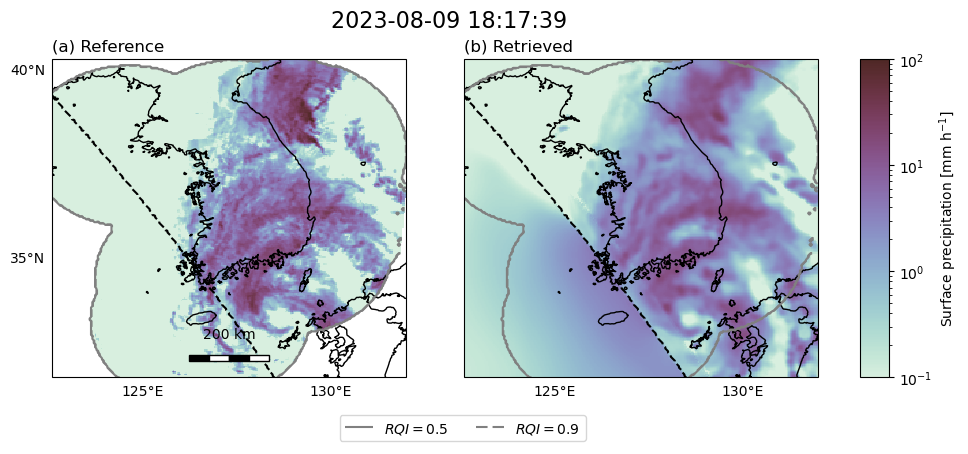

In [19]:
fig = evaluator.plot_retrieval_results(
    516,
    unet_retrieval,
    input_data_format="spatial",
    tile_size=256,
    batch_size=16,
    swath_boundaries=True
)

## Running the evaluation 

In [20]:
evaluator.evaluate(
    retrieval_fn=unet_retrieval,
    input_data_format="spatial",
    batch_size=32,
    n_processes=8,
    tile_size=256,
    overlap=64,
)

Output()

## Results

### Precipitation estimation

In [21]:
evaluator.get_precip_quantification_results(name="UNet (GMI)").T

,UNet (GMI),ERA5,GPROF V7 (GMI)
Bias [$\%$],-14.217926,-12.580348,-27.236600
MAE [$mm h^{-1}$],0.166723,0.212744,0.338000
MSE [$(mm h^{-1})^2$],1.653202,2.465700,5.175863
SMAPE$_{0.1}$ [$\%$],74.910504,105.643559,83.221078
Correlation coeff. [],0.680399,0.336344,0.650835
Effective resolution [$^\circ$],0.368536,inf,0.279000


### Precipitation detection

In [22]:
evaluator.get_precip_detection_results(name="UNet (GMI)").T

,UNet (GMI),ERA5,GPROF V7 (GMI)
POD [],0.589929,NaN,0.756630
FAR [],0.164549,NaN,0.351667
HSS [],0.821983,NaN,0.574699


### Probabilistic precipitation detection

In [23]:
evaluator.get_prob_precip_detection_results(name="UNet (GMI)").T

,UNet (GMI),ERA5,GPROF V7 (GMI)
AUC [],0.731906,0.0,0.54994


### Heavy precipitation detection

In [24]:
evaluator.get_heavy_precip_detection_results(name="UNet (GMI)").T

,UNet (GMI),ERA5,GPROF V7 (GMI)
POD [],0.142675,NaN,0.758366
FAR [],0.244165,NaN,0.462010
HSS [],0.755669,NaN,0.508161


### Probabilistic heavy precipitation detection

In [25]:
evaluator.get_prob_heavy_precip_detection_results(name="UNet (CPCIR)").T

,UNet (CPCIR),ERA5,GPROF V7 (GMI)
AUC [],0.488611,0.0,0.298044
